<a href="https://colab.research.google.com/github/Steve-YJ/Colab_Exercise/blob/master/Again_Training_Exp07_Final_20Epochs_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# README.MD
* Try Again, Fin...Fin...Fin...!!
* back to Original Kingma's VAE to Malimg
    * optimizer learning rate: 1e-3
    * optimizer params: sum
* Add 
    * plot train, test loss
        * save it every Epochs
    * plot latent vector per 10 Epoch
        * save it every 10 Epoch
    * save model's state dict per 10 Epoch
    * save latent vector per 10 Epoch

    * Change plot: add alpha parameter for visualization
* ✅ Check Point
    * Keep training Exp05
        * After Epoch 10, Train it
        * Reduce Learning rate: 1e-5 to 1e-3
    * Just Train 20 Epochs

## Reference
* Reference repository: https://github.com/pytorch/examples/tree/master/vae

* Reference for Visualization: https://github.com/tayden/VAE-Latent-Space-Explorer/blob/master/scripts/VAE.ipynb


In [1]:
! nvidia-smi

Sun Jul  5 02:19:06 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# drive mount
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
%cd drive/My\ Drive/InfoSec_Summer_part2
! pwd

/content/drive/My Drive/InfoSec_Summer_part2
/content/drive/My Drive/InfoSec_Summer_part2


## 01. Import Library

In [5]:
from PIL import Image
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
 
# https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b
import seaborn as sns

# save single numpy array
# https://numpy.org/doc/stable/reference/generated/numpy.save.html#numpy.save
from tempfile import TemporaryFile
from sklearn.manifold import TSNE

import torch
import torch.utils.data

from torch import nn, optim
from torch.nn import functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd

import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 02. Data Preprocessing
* Load dataset
* preprocess it
    * transforms
    * make custom dataset
    * train_test split: <code>torch.utils.data.random_split</code>
    * train_test_loader

### Work Flow
* transforms module 사용해서 image data compose 하기
    * size 조정, normalize, tensor 변환
* ImageFolder를 이용해 dataload
* dataset split: train dataset, test dataset
* DataLoader로 batch단위 dataset 불러오기

In [6]:
transforms = transforms.Compose([
                                transforms.Resize((224, 224)),                # Change size of Image to (224, 224)
                                transforms.Grayscale(num_output_channels=1),  # Makes it 1-dimension channel
                                transforms.ToTensor(),                        # Convert a PIL Image or numpy.ndarray to tensor.
                                                                              # Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0] if the PIL Image belongs to one of the modes (L, LA, P, I, F, RGB, YCbCr, RGBA, CMYK, 1) or if the numpy.ndarray has dtype = np.uint8
                                                                              # In the other cases, tensors are returned without scaling.
                                # transforms.Normalize(mean=[0.5], std=[0.5]),
                                
                                ])

# make custom dataset
trainset = torchvision.datasets.ImageFolder(root='../InformationSecurity_Summer/malimg',
                                            transform=transforms)  # make custom dataset

In [7]:
trainset

Dataset ImageFolder
    Number of datapoints: 9339
    Root location: ../InformationSecurity_Summer/malimg
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               Grayscale(num_output_channels=1)
               ToTensor()
           )

In [8]:
# classes = trainset.classes
classes = trainset.classes
classes

['Adialer.C',
 'Agent.FYI',
 'Allaple.A',
 'Allaple.L',
 'Alueron.gen!J',
 'Autorun.K',
 'C2LOP.P',
 'C2LOP.gen!g',
 'Dialplatform.B',
 'Dontovo.A',
 'Fakerean',
 'Instantaccess',
 'Lolyda.AA1',
 'Lolyda.AA2',
 'Lolyda.AA3',
 'Lolyda.AT',
 'Malex.gen!J',
 'Obfuscator.AD',
 'Rbot!gen',
 'Skintrim.N',
 'Swizzor.gen!E',
 'Swizzor.gen!I',
 'VB.AT',
 'Wintrim.BX',
 'Yuner.A']

In [9]:
full_dataset = trainset
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
print(train_size, test_size)

train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

7471 1868


In [10]:
'''
for idx, (data, _) in enumerate(test_dataset):
    if idx == 5: 
        break
    else:
        print(data, _)
'''

'\nfor idx, (data, _) in enumerate(test_dataset):\n    if idx == 5: \n        break\n    else:\n        print(data, _)\n'

In [11]:
train_loader = DataLoader(train_dataset,
                         batch_size=16,
                         shuffle=True,
                         pin_memory=True) 
test_loader = DataLoader(test_dataset,
                        batch_size=16,
                        shuffle=True,
                        pin_memory=True)  # Instead, we recommend using automatic memory pinning (i.e., setting pin_memory=True)
                                          #  which enables fast data transfer to CUDA-enabled GPUs

# First, insert all test dataset
# test_loader_10: testloader for latent vector visualization
test_loader_10 = DataLoader(test_dataset,
                        batch_size=1868,
                        shuffle=True,
                        pin_memory=True)

In [12]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    np_img = img.numpy()

    plt.imshow(np.transpose(np_img, (1, 2, 0)))  # Convert (C, W, H) to (W, H, C)

    print(np_img.shape)  # np_img shape
    print((np.transpose(np_img, (1, 2, 0))).shape)  # transposed shape 

In [13]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(labels)

tensor([ 7,  2, 24, 12, 11,  2, 10,  3, 11,  2, 13,  1,  7,  9,  2, 24])


torch.Size([16, 1, 224, 224])
(3, 906, 906)
(906, 906, 3)
torch.Size([16, 1, 224, 224])
torch.Size([3, 454, 1810])
C2LOP.gen!g Allaple.A Yuner.A Lolyda.AA1 Instantaccess Allaple.A Fakerean Allaple.L Instantaccess Allaple.A Lolyda.AA2 Agent.FYI C2LOP.gen!g Dontovo.A Allaple.A Yuner.A 


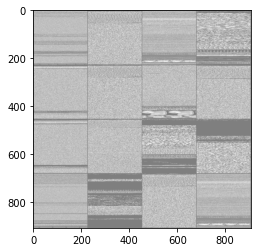

In [14]:
print(images.shape)
imshow(torchvision.utils.make_grid(images, nrow=4))
print(images.shape)
print((torchvision.utils.make_grid(images)).shape)
print("".join("%5s "%classes[labels[j]] for j in range(16)))

## 03. Define VAE Class
* Initialize
    * (224, 224) input 이미지를 통해 1차원 100개의 latent vector를 생성하는 Encoder네트워크 정의
    * 100개의 latent vector로부터 X_hat을 복원하는 Decoder Network 정의
* encode
* reparameterize
* decode
* forward

In [15]:
device = torch.device("cuda")  # device = torch.device("cuda")

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(224*224, 1000)
        self.fc21 = nn.Linear(1000, 100)
        self.fc22 = nn.Linear(1000, 100)
        self.fc3 = nn.Linear(100, 1000)
        self.fc4 = nn.Linear(1000, 224*224)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))
# loss값이 안줄면 sigmoid함수를 제거하고 BCE with Logits Loss를 사용해볼까?
# https://nuguziii.github.io/dev/dev-002/

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 224*224))
        z = self.reparameterize(mu, logvar)  # z's shape => (batch_size, 100)
        return self.decode(z), mu, logvar, z

### Load State Dict
* Exp05_Epoch10
* <code>Exp05_model_save_10Epochs.pth</code>

In [16]:
# Load State_dict
PATH_State_Dict = './Exp07_results/Exp05_model_save_10Epochs.pth'

model = VAE().to(device)
model.load_state_dict(torch.load(PATH_State_Dict))
model.eval

model

VAE(
  (fc1): Linear(in_features=50176, out_features=1000, bias=True)
  (fc21): Linear(in_features=1000, out_features=100, bias=True)
  (fc22): Linear(in_features=1000, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=1000, bias=True)
  (fc4): Linear(in_features=1000, out_features=50176, bias=True)
)

In [17]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [18]:
get_n_params(model)  

100704376

*Note*<br>
✅ Reducing Learning rate<br>
1e-3 to 1e-5

In [19]:
optimizer = optim.Adam(model.parameters(), lr=1e-5)  # reducing learning rate after 10 Epochs

In [20]:
# track and save train, test loss through Dictionary
# 
Epoch_Loss = {'train_epoch':[],
              'train_loss':[],
              'test_epoch':[],
              'test_loss':[]}

# Save & Loading Model for Inference
# Reference: https://pytorch.org/tutorials/beginner/saving_loading_models.html

# PATH = '/Again_original_Exp01_200-Epoch.pth'

PATH = 'Epochs.pth'
# latent_vector = np.zeros((16, 100))
color_palette = np.zeros((1868))


*Note*<br>
* Plot Every Epoch


In [21]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 224*224), reduction='sum')  # (input, target, ... reduction)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

def train(epoch):
    model.train()
    train_loss = 0
    # latent_vector = np.zeros(())
    # latent_label = 0

    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar, z= model(data)
    
       
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))
    
    Epoch_Loss['train_epoch'].append(epoch)
    Epoch_Loss['train_loss'].append(train_loss / len(train_loader.dataset))
   
def test(epoch):
    # Every Epoch 단위로 작업
    # model.state_dict() 저장 및 latent_vector 저장
    # plot latent vector
    # if epoch % 10 == 0:  # Epoch이 10의 배수일때
    # save model.state_dict() per 10 Epochs
    torch.save(model.state_dict(), ('./Exp07_results/model_save_' + str(epoch) + PATH))  # Epoch 단위 parameter 저장

    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar, z = model(data)
            # z vector는 torch type
            # latent_vector = z.detach().cpu().clone().numpy()
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                    recon_batch.view(16, 1, 224, 224)[:n]])
                save_image(comparison.cpu(),
                        './Exp07_results/recon_sampling/reconstruction_' + str(epoch) + '.png', nrow=n)
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    Epoch_Loss['test_epoch'].append(epoch)
    Epoch_Loss['test_loss'].append(test_loss)

    # save latent vector's every 10 Epoch's
    # load_whole test_data 
    for i, (data, _) in enumerate(test_loader_10):  # load_whole test_data
        data = data.to(device)
        recon_batch, mu, logvar, z = model(data)
    # save latent_vector per 10 Epochs
        latent_vector = z.detach().cpu().clone().numpy()  # change tensor type data to cpu().numpy()
                                                            # latent_vector_size: (num_of_data, 100)
        color_palette = _.detach().cpu().clone().numpy()
        with open(('./Exp07_results/'+str(epoch)+'Epoch_z_vector.npy'), 'wb') as f:
            np.save(f, latent_vector)  # but latent vector size is (16, 100).... just 16...
                                        # 10 Epoch 단위로 latent vector를 저장한다
                                        # 이 떄, latent vector의 size는 test_dataset의 크기가 되어야 한다
                                        # 결과값이 좋은 vector는 좋은 feature로 사용할 수 있다.
    # plot latent vector Every 10 Epochs
    # t-SNE for Dimensionality reduction
    Z_embedded = TSNE(n_components=2).fit_transform(latent_vector)
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))  # setup the plot

    x = Z_embedded[:, 0]
    y = Z_embedded[:, 1]
    label = color_palette
    # label[10:12] = 0  # make sure there are some 0 values to show up as grey
    print("=="*20, "params", "=="*20)
    print("Z_embedded.shape:", Z_embedded.shape)
    print("label.shape:", label.shape)
    # tsne_data = np.vstack((Z_embedded, label))
    tsne_data = np.c_[Z_embedded, label]
    tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
    sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
    plt.savefig('./Exp07_results/plot_latent_vector/' + str(epoch) + '_t_SNE.png', dpi=300)
    plt.show()
'''
    elif epoch % 10 !=0:
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for i, (data, _) in enumerate(test_loader):
                data = data.to(device)
                recon_batch, mu, logvar, z = model(data)
                # z vector는 torch type
                # latent_vector = z.detach().cpu().clone().numpy()
                test_loss += loss_function(recon_batch, data, mu, logvar).item()
                if i == 0:
                    n = min(data.size(0), 8)
                    comparison = torch.cat([data[:n],
                                        recon_batch.view(16, 1, 224, 224)[:n]])
                    save_image(comparison.cpu(),
                            './Exp06_results/recon_sampling/reconstruction_' + str(epoch) + '.png', nrow=n)
        test_loss /= len(test_loader.dataset)
        print('====> Test set loss: {:.4f}'.format(test_loss))
        Epoch_Loss['test_epoch'].append(epoch)
        Epoch_Loss['test_loss'].append(test_loss)
'''

"\n    elif epoch % 10 !=0:\n        model.eval()\n        test_loss = 0\n        with torch.no_grad():\n            for i, (data, _) in enumerate(test_loader):\n                data = data.to(device)\n                recon_batch, mu, logvar, z = model(data)\n                # z vector는 torch type\n                # latent_vector = z.detach().cpu().clone().numpy()\n                test_loss += loss_function(recon_batch, data, mu, logvar).item()\n                if i == 0:\n                    n = min(data.size(0), 8)\n                    comparison = torch.cat([data[:n],\n                                        recon_batch.view(16, 1, 224, 224)[:n]])\n                    save_image(comparison.cpu(),\n                            './Exp06_results/recon_sampling/reconstruction_' + str(epoch) + '.png', nrow=n)\n        test_loss /= len(test_loader.dataset)\n        print('====> Test set loss: {:.4f}'.format(test_loss))\n        Epoch_Loss['test_epoch'].append(epoch)\n        Epoch_Loss['te

*Notice*<br>
Train Again!<br>
Change BCE loss param_reduction to 'sum'

1
Train Epoch: 1 [0/7471 (0%)]	Loss: 32557.667969
Train Epoch: 1 [160/7471 (2%)]	Loss: 31420.740234
Train Epoch: 1 [320/7471 (4%)]	Loss: 32926.402344
Train Epoch: 1 [480/7471 (6%)]	Loss: 33575.804688
Train Epoch: 1 [640/7471 (9%)]	Loss: 32370.595703
Train Epoch: 1 [800/7471 (11%)]	Loss: 32382.582031
Train Epoch: 1 [960/7471 (13%)]	Loss: 32381.728516
Train Epoch: 1 [1120/7471 (15%)]	Loss: 32375.660156
Train Epoch: 1 [1280/7471 (17%)]	Loss: 31722.000000
Train Epoch: 1 [1440/7471 (19%)]	Loss: 32653.226562
Train Epoch: 1 [1600/7471 (21%)]	Loss: 32898.109375
Train Epoch: 1 [1760/7471 (24%)]	Loss: 32974.562500
Train Epoch: 1 [1920/7471 (26%)]	Loss: 32961.148438
Train Epoch: 1 [2080/7471 (28%)]	Loss: 32460.404297
Train Epoch: 1 [2240/7471 (30%)]	Loss: 33204.203125
Train Epoch: 1 [2400/7471 (32%)]	Loss: 32255.035156
Train Epoch: 1 [2560/7471 (34%)]	Loss: 32390.613281
Train Epoch: 1 [2720/7471 (36%)]	Loss: 31476.169922
Train Epoch: 1 [2880/7471 (39%)]	Loss: 33102.453125
Train Epoch: 1 [3040/747

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


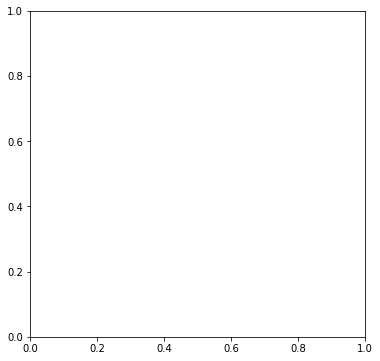

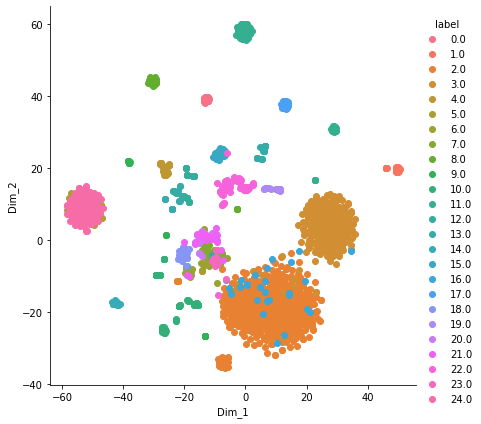

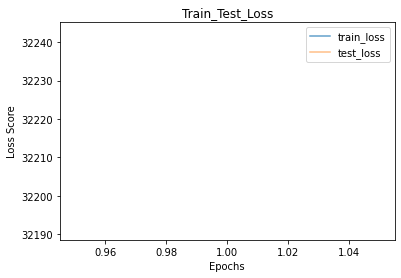

2
Train Epoch: 2 [0/7471 (0%)]	Loss: 33194.468750
Train Epoch: 2 [160/7471 (2%)]	Loss: 31530.494141
Train Epoch: 2 [320/7471 (4%)]	Loss: 33363.777344
Train Epoch: 2 [480/7471 (6%)]	Loss: 32970.378906
Train Epoch: 2 [640/7471 (9%)]	Loss: 32183.126953
Train Epoch: 2 [800/7471 (11%)]	Loss: 31431.992188
Train Epoch: 2 [960/7471 (13%)]	Loss: 32939.589844
Train Epoch: 2 [1120/7471 (15%)]	Loss: 31811.234375
Train Epoch: 2 [1280/7471 (17%)]	Loss: 31578.589844
Train Epoch: 2 [1440/7471 (19%)]	Loss: 31224.330078
Train Epoch: 2 [1600/7471 (21%)]	Loss: 33168.585938
Train Epoch: 2 [1760/7471 (24%)]	Loss: 33320.964844
Train Epoch: 2 [1920/7471 (26%)]	Loss: 31786.519531
Train Epoch: 2 [2080/7471 (28%)]	Loss: 31217.593750
Train Epoch: 2 [2240/7471 (30%)]	Loss: 31704.712891
Train Epoch: 2 [2400/7471 (32%)]	Loss: 31976.404297
Train Epoch: 2 [2560/7471 (34%)]	Loss: 32150.921875
Train Epoch: 2 [2720/7471 (36%)]	Loss: 31137.367188
Train Epoch: 2 [2880/7471 (39%)]	Loss: 29959.041016
Train Epoch: 2 [3040/747

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


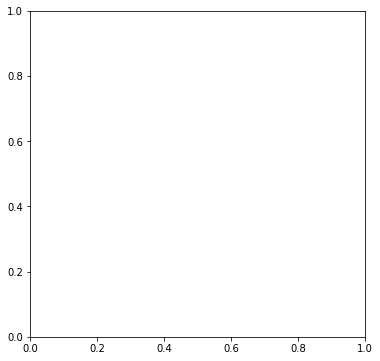

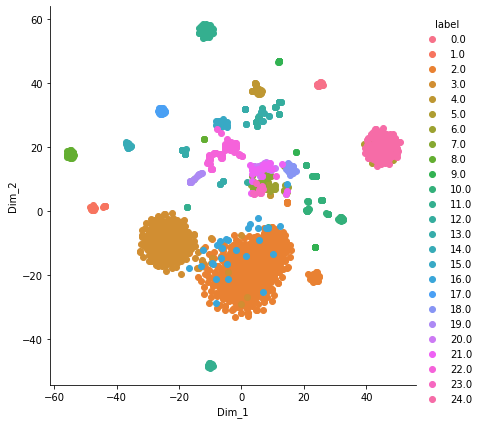

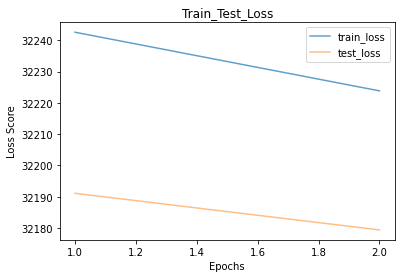

3
Train Epoch: 3 [0/7471 (0%)]	Loss: 31159.386719
Train Epoch: 3 [160/7471 (2%)]	Loss: 32340.257812
Train Epoch: 3 [320/7471 (4%)]	Loss: 33181.632812
Train Epoch: 3 [480/7471 (6%)]	Loss: 32956.617188
Train Epoch: 3 [640/7471 (9%)]	Loss: 32685.113281
Train Epoch: 3 [800/7471 (11%)]	Loss: 31991.580078
Train Epoch: 3 [960/7471 (13%)]	Loss: 31904.865234
Train Epoch: 3 [1120/7471 (15%)]	Loss: 30759.359375
Train Epoch: 3 [1280/7471 (17%)]	Loss: 30184.482422
Train Epoch: 3 [1440/7471 (19%)]	Loss: 31397.855469
Train Epoch: 3 [1600/7471 (21%)]	Loss: 30040.333984
Train Epoch: 3 [1760/7471 (24%)]	Loss: 32435.232422
Train Epoch: 3 [1920/7471 (26%)]	Loss: 32203.650391
Train Epoch: 3 [2080/7471 (28%)]	Loss: 31916.167969
Train Epoch: 3 [2240/7471 (30%)]	Loss: 32936.488281
Train Epoch: 3 [2400/7471 (32%)]	Loss: 33511.644531
Train Epoch: 3 [2560/7471 (34%)]	Loss: 31064.621094
Train Epoch: 3 [2720/7471 (36%)]	Loss: 32904.832031
Train Epoch: 3 [2880/7471 (39%)]	Loss: 32891.914062
Train Epoch: 3 [3040/747

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


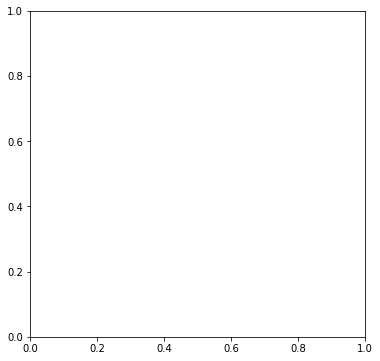

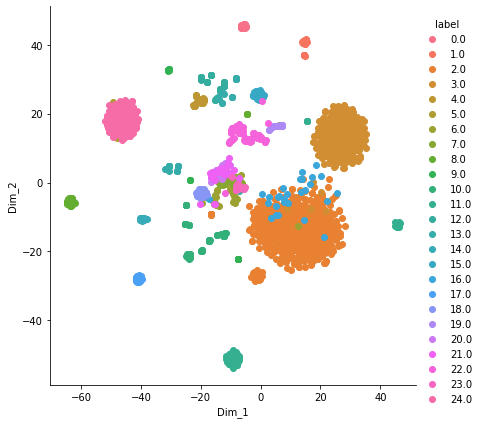

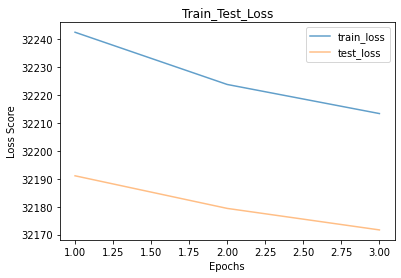

4
Train Epoch: 4 [0/7471 (0%)]	Loss: 33550.617188
Train Epoch: 4 [160/7471 (2%)]	Loss: 33261.578125
Train Epoch: 4 [320/7471 (4%)]	Loss: 33657.574219
Train Epoch: 4 [480/7471 (6%)]	Loss: 31972.119141
Train Epoch: 4 [640/7471 (9%)]	Loss: 31375.636719
Train Epoch: 4 [800/7471 (11%)]	Loss: 31824.189453
Train Epoch: 4 [960/7471 (13%)]	Loss: 32109.103516
Train Epoch: 4 [1120/7471 (15%)]	Loss: 31853.384766
Train Epoch: 4 [1280/7471 (17%)]	Loss: 31468.027344
Train Epoch: 4 [1440/7471 (19%)]	Loss: 32352.005859
Train Epoch: 4 [1600/7471 (21%)]	Loss: 31781.251953
Train Epoch: 4 [1760/7471 (24%)]	Loss: 32177.832031
Train Epoch: 4 [1920/7471 (26%)]	Loss: 32305.933594
Train Epoch: 4 [2080/7471 (28%)]	Loss: 31287.505859
Train Epoch: 4 [2240/7471 (30%)]	Loss: 33542.332031
Train Epoch: 4 [2400/7471 (32%)]	Loss: 33130.917969
Train Epoch: 4 [2560/7471 (34%)]	Loss: 31953.992188
Train Epoch: 4 [2720/7471 (36%)]	Loss: 33251.031250
Train Epoch: 4 [2880/7471 (39%)]	Loss: 32642.916016
Train Epoch: 4 [3040/747

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


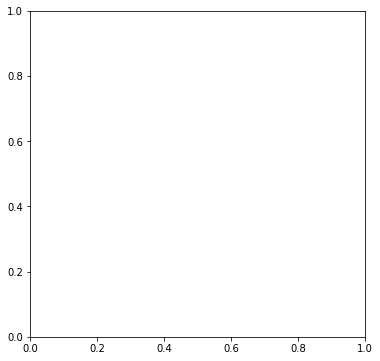

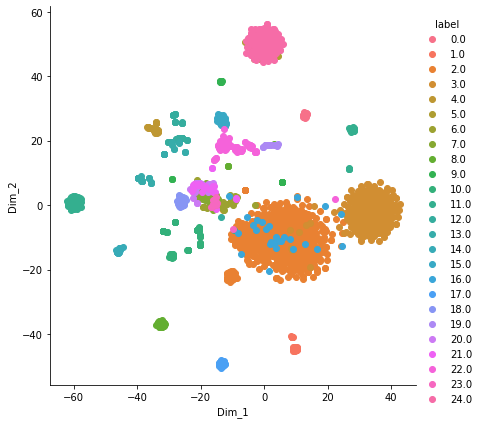

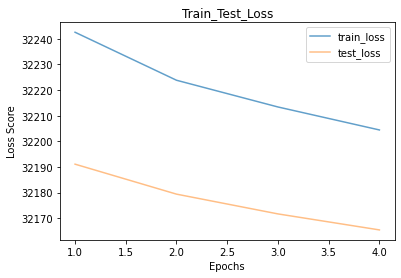

5
Train Epoch: 5 [0/7471 (0%)]	Loss: 32876.121094
Train Epoch: 5 [160/7471 (2%)]	Loss: 31753.957031
Train Epoch: 5 [320/7471 (4%)]	Loss: 32131.292969
Train Epoch: 5 [480/7471 (6%)]	Loss: 31431.816406
Train Epoch: 5 [640/7471 (9%)]	Loss: 31794.923828
Train Epoch: 5 [800/7471 (11%)]	Loss: 31002.794922
Train Epoch: 5 [960/7471 (13%)]	Loss: 32308.626953
Train Epoch: 5 [1120/7471 (15%)]	Loss: 32735.960938
Train Epoch: 5 [1280/7471 (17%)]	Loss: 28808.613281
Train Epoch: 5 [1440/7471 (19%)]	Loss: 32923.972656
Train Epoch: 5 [1600/7471 (21%)]	Loss: 33341.644531
Train Epoch: 5 [1760/7471 (24%)]	Loss: 32849.136719
Train Epoch: 5 [1920/7471 (26%)]	Loss: 31637.830078
Train Epoch: 5 [2080/7471 (28%)]	Loss: 32701.720703
Train Epoch: 5 [2240/7471 (30%)]	Loss: 33108.796875
Train Epoch: 5 [2400/7471 (32%)]	Loss: 32694.703125
Train Epoch: 5 [2560/7471 (34%)]	Loss: 33480.664062
Train Epoch: 5 [2720/7471 (36%)]	Loss: 33111.890625
Train Epoch: 5 [2880/7471 (39%)]	Loss: 30505.054688
Train Epoch: 5 [3040/747

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


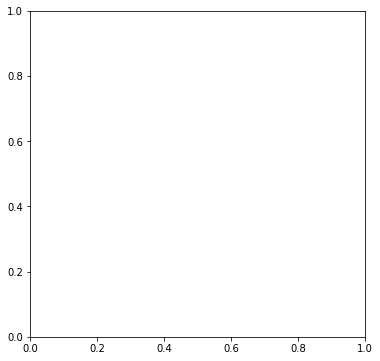

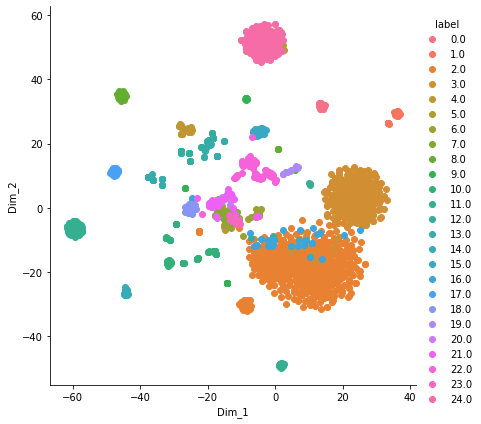

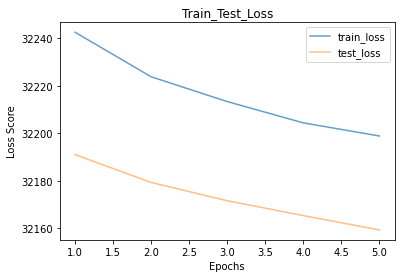

6
Train Epoch: 6 [0/7471 (0%)]	Loss: 32864.937500
Train Epoch: 6 [160/7471 (2%)]	Loss: 31573.664062
Train Epoch: 6 [320/7471 (4%)]	Loss: 33244.570312
Train Epoch: 6 [480/7471 (6%)]	Loss: 33635.429688
Train Epoch: 6 [640/7471 (9%)]	Loss: 30995.457031
Train Epoch: 6 [800/7471 (11%)]	Loss: 32444.076172
Train Epoch: 6 [960/7471 (13%)]	Loss: 31661.765625
Train Epoch: 6 [1120/7471 (15%)]	Loss: 31544.818359
Train Epoch: 6 [1280/7471 (17%)]	Loss: 32919.945312
Train Epoch: 6 [1440/7471 (19%)]	Loss: 34072.156250
Train Epoch: 6 [1600/7471 (21%)]	Loss: 32602.662109
Train Epoch: 6 [1760/7471 (24%)]	Loss: 32646.824219
Train Epoch: 6 [1920/7471 (26%)]	Loss: 30506.623047
Train Epoch: 6 [2080/7471 (28%)]	Loss: 33156.460938
Train Epoch: 6 [2240/7471 (30%)]	Loss: 32595.109375
Train Epoch: 6 [2400/7471 (32%)]	Loss: 32028.871094
Train Epoch: 6 [2560/7471 (34%)]	Loss: 32473.591797
Train Epoch: 6 [2720/7471 (36%)]	Loss: 30410.095703
Train Epoch: 6 [2880/7471 (39%)]	Loss: 32327.802734
Train Epoch: 6 [3040/747

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


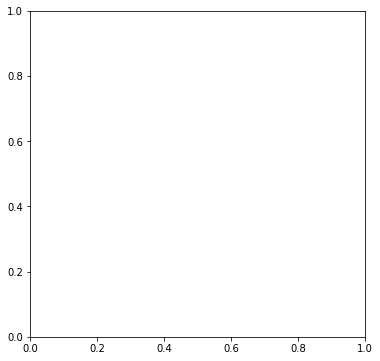

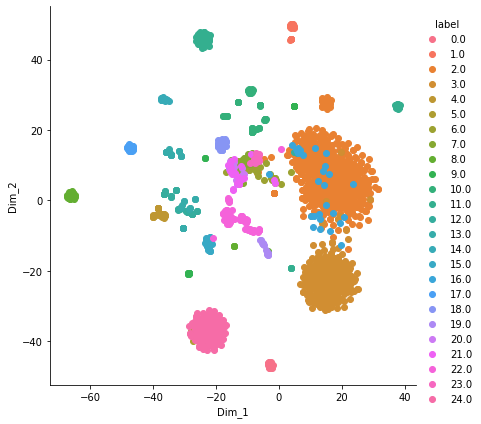

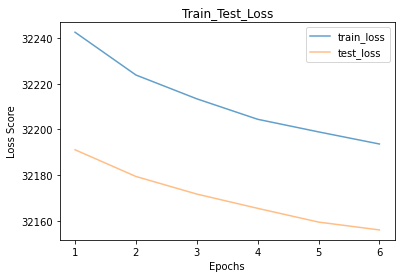

7
Train Epoch: 7 [0/7471 (0%)]	Loss: 30632.384766
Train Epoch: 7 [160/7471 (2%)]	Loss: 32250.849609
Train Epoch: 7 [320/7471 (4%)]	Loss: 32888.199219
Train Epoch: 7 [480/7471 (6%)]	Loss: 31034.298828
Train Epoch: 7 [640/7471 (9%)]	Loss: 32547.765625
Train Epoch: 7 [800/7471 (11%)]	Loss: 33106.871094
Train Epoch: 7 [960/7471 (13%)]	Loss: 31996.984375
Train Epoch: 7 [1120/7471 (15%)]	Loss: 32337.070312
Train Epoch: 7 [1280/7471 (17%)]	Loss: 32737.013672
Train Epoch: 7 [1440/7471 (19%)]	Loss: 32001.630859
Train Epoch: 7 [1600/7471 (21%)]	Loss: 32317.972656
Train Epoch: 7 [1760/7471 (24%)]	Loss: 33075.652344
Train Epoch: 7 [1920/7471 (26%)]	Loss: 31464.298828
Train Epoch: 7 [2080/7471 (28%)]	Loss: 32423.068359
Train Epoch: 7 [2240/7471 (30%)]	Loss: 33202.160156
Train Epoch: 7 [2400/7471 (32%)]	Loss: 32149.107422
Train Epoch: 7 [2560/7471 (34%)]	Loss: 32206.324219
Train Epoch: 7 [2720/7471 (36%)]	Loss: 32886.832031
Train Epoch: 7 [2880/7471 (39%)]	Loss: 31213.322266
Train Epoch: 7 [3040/747

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


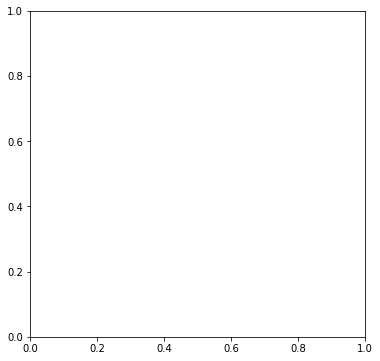

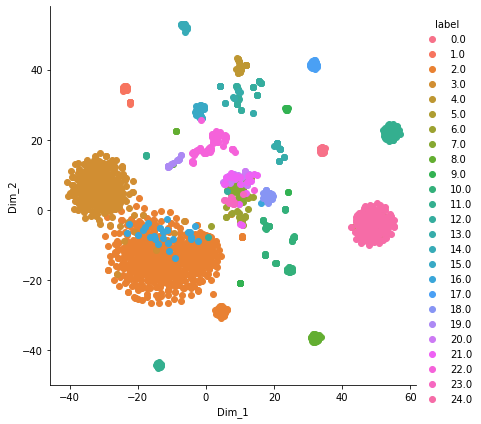

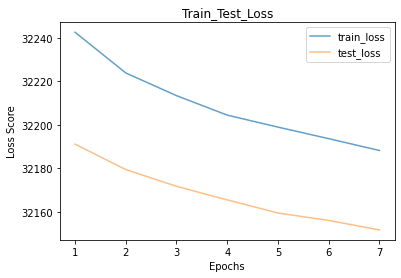

8
Train Epoch: 8 [0/7471 (0%)]	Loss: 32782.878906
Train Epoch: 8 [160/7471 (2%)]	Loss: 32150.359375
Train Epoch: 8 [320/7471 (4%)]	Loss: 32543.398438
Train Epoch: 8 [480/7471 (6%)]	Loss: 33261.132812
Train Epoch: 8 [640/7471 (9%)]	Loss: 32873.699219
Train Epoch: 8 [800/7471 (11%)]	Loss: 32726.683594
Train Epoch: 8 [960/7471 (13%)]	Loss: 32034.273438
Train Epoch: 8 [1120/7471 (15%)]	Loss: 32751.847656
Train Epoch: 8 [1280/7471 (17%)]	Loss: 32562.542969
Train Epoch: 8 [1440/7471 (19%)]	Loss: 32409.144531
Train Epoch: 8 [1600/7471 (21%)]	Loss: 33074.968750
Train Epoch: 8 [1760/7471 (24%)]	Loss: 31899.294922
Train Epoch: 8 [1920/7471 (26%)]	Loss: 33124.078125
Train Epoch: 8 [2080/7471 (28%)]	Loss: 32218.845703
Train Epoch: 8 [2240/7471 (30%)]	Loss: 32690.154297
Train Epoch: 8 [2400/7471 (32%)]	Loss: 29919.906250
Train Epoch: 8 [2560/7471 (34%)]	Loss: 32345.472656
Train Epoch: 8 [2720/7471 (36%)]	Loss: 33155.812500
Train Epoch: 8 [2880/7471 (39%)]	Loss: 33485.488281
Train Epoch: 8 [3040/747

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


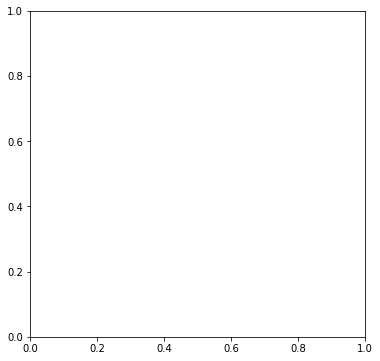

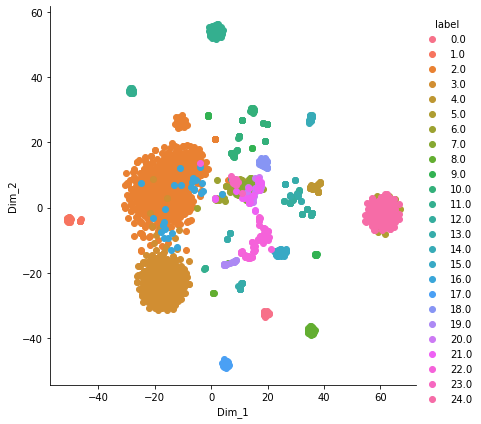

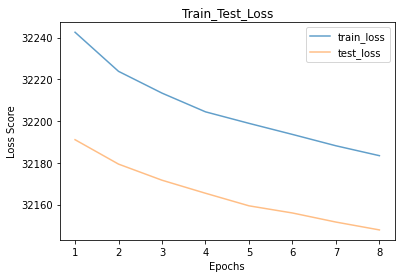

9
Train Epoch: 9 [0/7471 (0%)]	Loss: 31228.171875
Train Epoch: 9 [160/7471 (2%)]	Loss: 32228.796875
Train Epoch: 9 [320/7471 (4%)]	Loss: 32535.984375
Train Epoch: 9 [480/7471 (6%)]	Loss: 33255.066406
Train Epoch: 9 [640/7471 (9%)]	Loss: 32832.527344
Train Epoch: 9 [800/7471 (11%)]	Loss: 32826.066406
Train Epoch: 9 [960/7471 (13%)]	Loss: 29939.001953
Train Epoch: 9 [1120/7471 (15%)]	Loss: 32903.578125
Train Epoch: 9 [1280/7471 (17%)]	Loss: 33088.992188
Train Epoch: 9 [1440/7471 (19%)]	Loss: 31563.544922
Train Epoch: 9 [1600/7471 (21%)]	Loss: 33089.734375
Train Epoch: 9 [1760/7471 (24%)]	Loss: 30272.158203
Train Epoch: 9 [1920/7471 (26%)]	Loss: 30796.207031
Train Epoch: 9 [2080/7471 (28%)]	Loss: 32907.015625
Train Epoch: 9 [2240/7471 (30%)]	Loss: 32515.621094
Train Epoch: 9 [2400/7471 (32%)]	Loss: 31527.037109
Train Epoch: 9 [2560/7471 (34%)]	Loss: 32499.660156
Train Epoch: 9 [2720/7471 (36%)]	Loss: 30407.152344
Train Epoch: 9 [2880/7471 (39%)]	Loss: 32751.097656
Train Epoch: 9 [3040/747

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


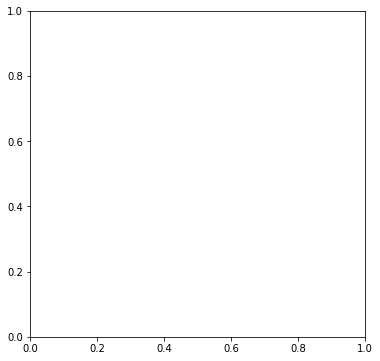

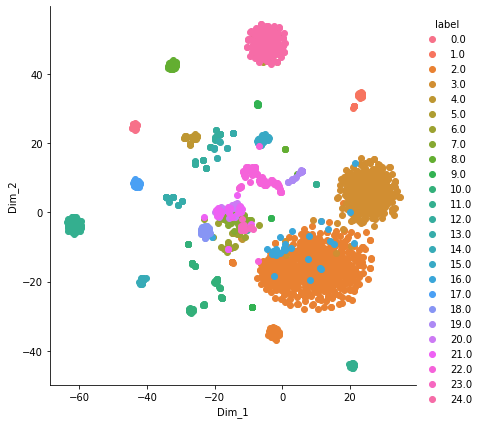

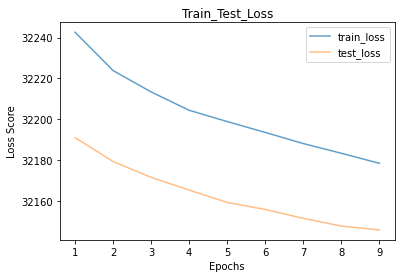

10
Train Epoch: 10 [0/7471 (0%)]	Loss: 31342.271484
Train Epoch: 10 [160/7471 (2%)]	Loss: 31420.962891
Train Epoch: 10 [320/7471 (4%)]	Loss: 33390.871094
Train Epoch: 10 [480/7471 (6%)]	Loss: 30632.984375
Train Epoch: 10 [640/7471 (9%)]	Loss: 31380.095703
Train Epoch: 10 [800/7471 (11%)]	Loss: 32458.212891
Train Epoch: 10 [960/7471 (13%)]	Loss: 31453.843750
Train Epoch: 10 [1120/7471 (15%)]	Loss: 33813.296875
Train Epoch: 10 [1280/7471 (17%)]	Loss: 32176.277344
Train Epoch: 10 [1440/7471 (19%)]	Loss: 30522.027344
Train Epoch: 10 [1600/7471 (21%)]	Loss: 32031.865234
Train Epoch: 10 [1760/7471 (24%)]	Loss: 32015.310547
Train Epoch: 10 [1920/7471 (26%)]	Loss: 32823.550781
Train Epoch: 10 [2080/7471 (28%)]	Loss: 32207.851562
Train Epoch: 10 [2240/7471 (30%)]	Loss: 32381.396484
Train Epoch: 10 [2400/7471 (32%)]	Loss: 33749.597656
Train Epoch: 10 [2560/7471 (34%)]	Loss: 30782.498047
Train Epoch: 10 [2720/7471 (36%)]	Loss: 32073.609375
Train Epoch: 10 [2880/7471 (39%)]	Loss: 32863.238281
Trai

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


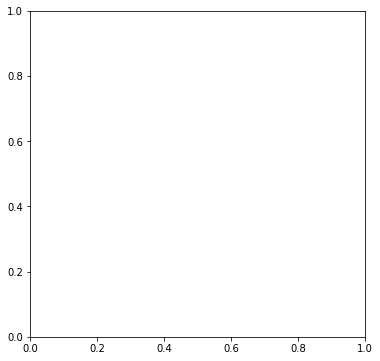

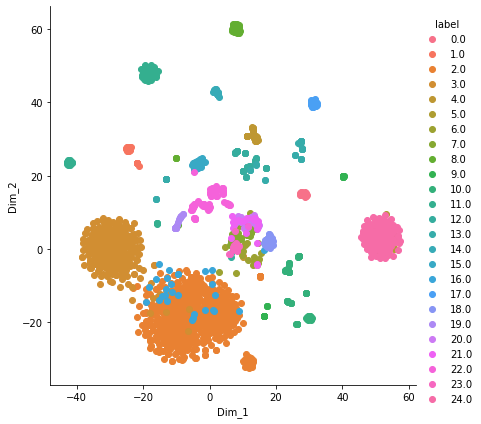

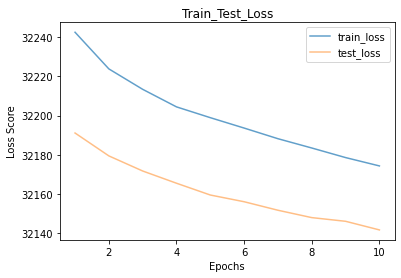

11
Train Epoch: 11 [0/7471 (0%)]	Loss: 32403.857422
Train Epoch: 11 [160/7471 (2%)]	Loss: 30159.082031
Train Epoch: 11 [320/7471 (4%)]	Loss: 31156.015625
Train Epoch: 11 [480/7471 (6%)]	Loss: 31666.134766
Train Epoch: 11 [640/7471 (9%)]	Loss: 30907.255859
Train Epoch: 11 [800/7471 (11%)]	Loss: 32909.988281
Train Epoch: 11 [960/7471 (13%)]	Loss: 31002.767578
Train Epoch: 11 [1120/7471 (15%)]	Loss: 32243.154297
Train Epoch: 11 [1280/7471 (17%)]	Loss: 32380.509766
Train Epoch: 11 [1440/7471 (19%)]	Loss: 32096.062500
Train Epoch: 11 [1600/7471 (21%)]	Loss: 30540.687500
Train Epoch: 11 [1760/7471 (24%)]	Loss: 32766.980469
Train Epoch: 11 [1920/7471 (26%)]	Loss: 32061.451172
Train Epoch: 11 [2080/7471 (28%)]	Loss: 33226.378906
Train Epoch: 11 [2240/7471 (30%)]	Loss: 32670.326172
Train Epoch: 11 [2400/7471 (32%)]	Loss: 33359.289062
Train Epoch: 11 [2560/7471 (34%)]	Loss: 32942.812500
Train Epoch: 11 [2720/7471 (36%)]	Loss: 32009.537109
Train Epoch: 11 [2880/7471 (39%)]	Loss: 31155.740234
Trai

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


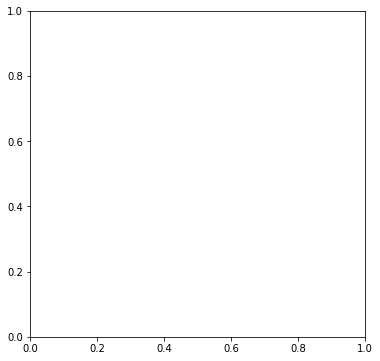

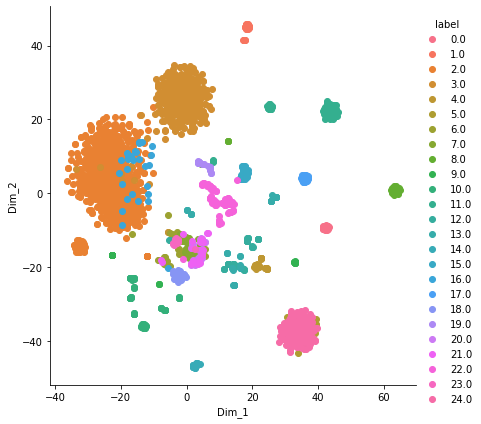

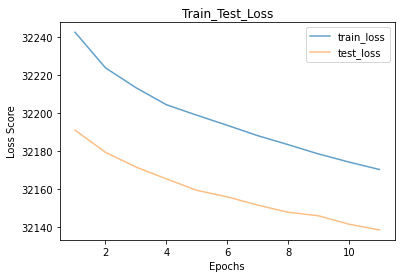

12
Train Epoch: 12 [0/7471 (0%)]	Loss: 31829.212891
Train Epoch: 12 [160/7471 (2%)]	Loss: 32745.839844
Train Epoch: 12 [320/7471 (4%)]	Loss: 32617.064453
Train Epoch: 12 [480/7471 (6%)]	Loss: 32331.652344
Train Epoch: 12 [640/7471 (9%)]	Loss: 31860.218750
Train Epoch: 12 [800/7471 (11%)]	Loss: 32325.218750
Train Epoch: 12 [960/7471 (13%)]	Loss: 30588.074219
Train Epoch: 12 [1120/7471 (15%)]	Loss: 31766.193359
Train Epoch: 12 [1280/7471 (17%)]	Loss: 32184.839844
Train Epoch: 12 [1440/7471 (19%)]	Loss: 32577.242188
Train Epoch: 12 [1600/7471 (21%)]	Loss: 33410.250000
Train Epoch: 12 [1760/7471 (24%)]	Loss: 32918.566406
Train Epoch: 12 [1920/7471 (26%)]	Loss: 32529.302734
Train Epoch: 12 [2080/7471 (28%)]	Loss: 32276.300781
Train Epoch: 12 [2240/7471 (30%)]	Loss: 30598.201172
Train Epoch: 12 [2400/7471 (32%)]	Loss: 31116.484375
Train Epoch: 12 [2560/7471 (34%)]	Loss: 32176.035156
Train Epoch: 12 [2720/7471 (36%)]	Loss: 31768.251953
Train Epoch: 12 [2880/7471 (39%)]	Loss: 31613.541016
Trai

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


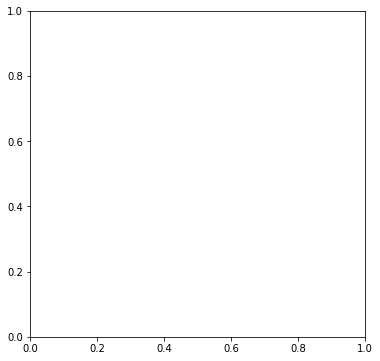

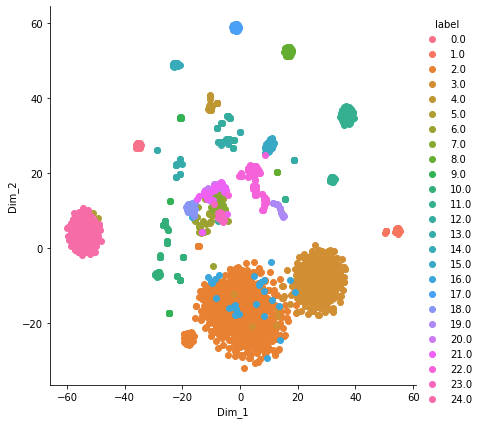

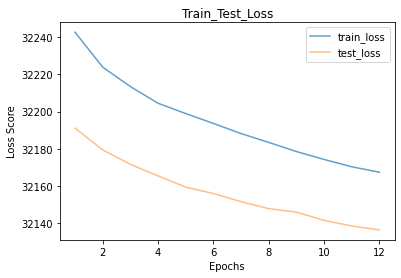

13
Train Epoch: 13 [0/7471 (0%)]	Loss: 33050.718750
Train Epoch: 13 [160/7471 (2%)]	Loss: 30717.259766
Train Epoch: 13 [320/7471 (4%)]	Loss: 31536.917969
Train Epoch: 13 [480/7471 (6%)]	Loss: 32346.496094
Train Epoch: 13 [640/7471 (9%)]	Loss: 32297.451172
Train Epoch: 13 [800/7471 (11%)]	Loss: 32424.255859
Train Epoch: 13 [960/7471 (13%)]	Loss: 32787.402344
Train Epoch: 13 [1120/7471 (15%)]	Loss: 33204.937500
Train Epoch: 13 [1280/7471 (17%)]	Loss: 31173.388672
Train Epoch: 13 [1440/7471 (19%)]	Loss: 33625.765625
Train Epoch: 13 [1600/7471 (21%)]	Loss: 31687.226562
Train Epoch: 13 [1760/7471 (24%)]	Loss: 30957.236328
Train Epoch: 13 [1920/7471 (26%)]	Loss: 32480.615234
Train Epoch: 13 [2080/7471 (28%)]	Loss: 31692.578125
Train Epoch: 13 [2240/7471 (30%)]	Loss: 31088.119141
Train Epoch: 13 [2400/7471 (32%)]	Loss: 31545.839844
Train Epoch: 13 [2560/7471 (34%)]	Loss: 33140.878906
Train Epoch: 13 [2720/7471 (36%)]	Loss: 32441.505859
Train Epoch: 13 [2880/7471 (39%)]	Loss: 31620.931641
Trai

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


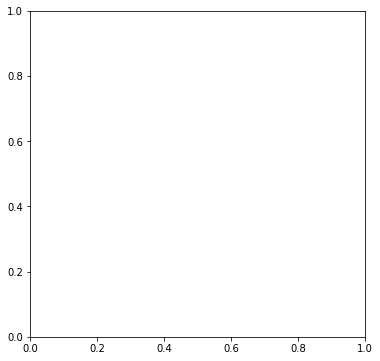

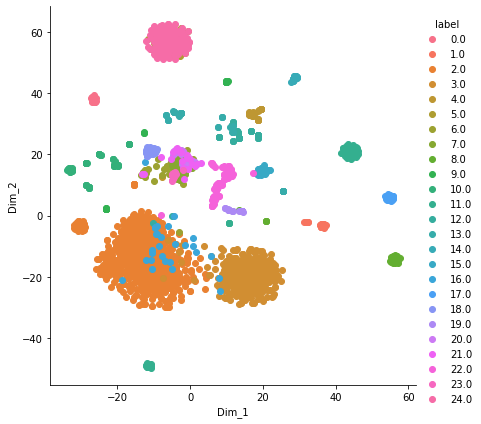

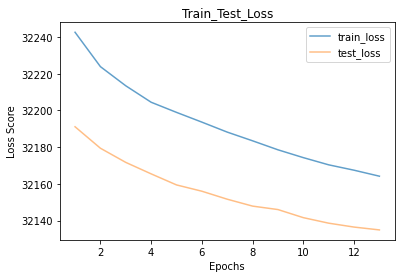

14
Train Epoch: 14 [0/7471 (0%)]	Loss: 32115.279297
Train Epoch: 14 [160/7471 (2%)]	Loss: 33743.769531
Train Epoch: 14 [320/7471 (4%)]	Loss: 31057.039062
Train Epoch: 14 [480/7471 (6%)]	Loss: 32674.935547
Train Epoch: 14 [640/7471 (9%)]	Loss: 31453.998047
Train Epoch: 14 [800/7471 (11%)]	Loss: 31682.873047
Train Epoch: 14 [960/7471 (13%)]	Loss: 30985.607422
Train Epoch: 14 [1120/7471 (15%)]	Loss: 33082.582031
Train Epoch: 14 [1280/7471 (17%)]	Loss: 31945.828125
Train Epoch: 14 [1440/7471 (19%)]	Loss: 31696.429688
Train Epoch: 14 [1600/7471 (21%)]	Loss: 33246.375000
Train Epoch: 14 [1760/7471 (24%)]	Loss: 33238.964844
Train Epoch: 14 [1920/7471 (26%)]	Loss: 32722.406250
Train Epoch: 14 [2080/7471 (28%)]	Loss: 32512.287109
Train Epoch: 14 [2240/7471 (30%)]	Loss: 32476.103516
Train Epoch: 14 [2400/7471 (32%)]	Loss: 33099.570312
Train Epoch: 14 [2560/7471 (34%)]	Loss: 32709.525391
Train Epoch: 14 [2720/7471 (36%)]	Loss: 30953.533203
Train Epoch: 14 [2880/7471 (39%)]	Loss: 29760.519531
Trai

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


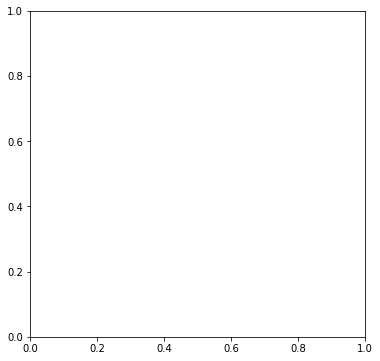

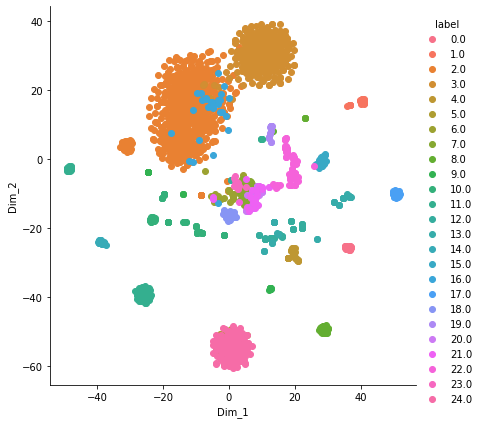

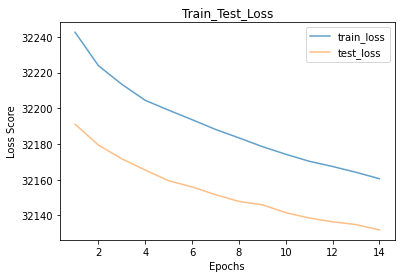

15
Train Epoch: 15 [0/7471 (0%)]	Loss: 32914.242188
Train Epoch: 15 [160/7471 (2%)]	Loss: 32926.492188
Train Epoch: 15 [320/7471 (4%)]	Loss: 32685.886719
Train Epoch: 15 [480/7471 (6%)]	Loss: 32301.082031
Train Epoch: 15 [640/7471 (9%)]	Loss: 32616.304688
Train Epoch: 15 [800/7471 (11%)]	Loss: 31543.726562
Train Epoch: 15 [960/7471 (13%)]	Loss: 31829.994141
Train Epoch: 15 [1120/7471 (15%)]	Loss: 30402.701172
Train Epoch: 15 [1280/7471 (17%)]	Loss: 31128.306641
Train Epoch: 15 [1440/7471 (19%)]	Loss: 32462.009766
Train Epoch: 15 [1600/7471 (21%)]	Loss: 31135.261719
Train Epoch: 15 [1760/7471 (24%)]	Loss: 33127.312500
Train Epoch: 15 [1920/7471 (26%)]	Loss: 33027.574219
Train Epoch: 15 [2080/7471 (28%)]	Loss: 32330.962891
Train Epoch: 15 [2240/7471 (30%)]	Loss: 33142.750000
Train Epoch: 15 [2400/7471 (32%)]	Loss: 32741.310547
Train Epoch: 15 [2560/7471 (34%)]	Loss: 33827.863281
Train Epoch: 15 [2720/7471 (36%)]	Loss: 32092.267578
Train Epoch: 15 [2880/7471 (39%)]	Loss: 32235.314453
Trai

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


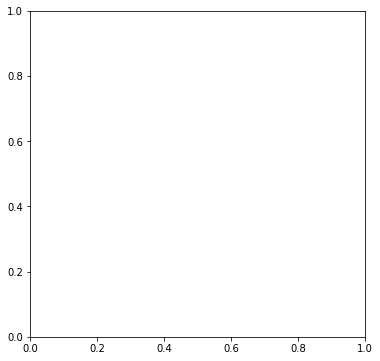

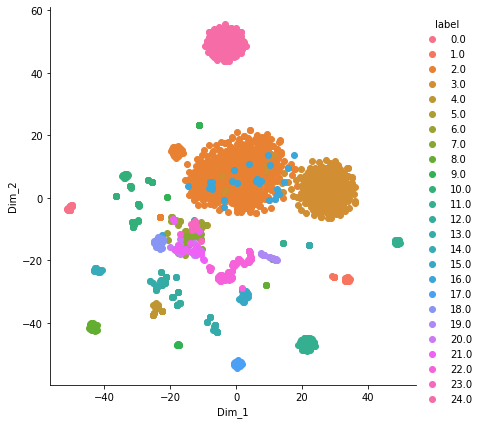

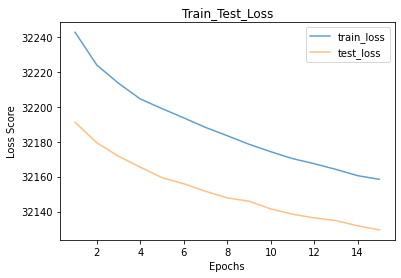

16
Train Epoch: 16 [0/7471 (0%)]	Loss: 31911.212891
Train Epoch: 16 [160/7471 (2%)]	Loss: 32009.621094
Train Epoch: 16 [320/7471 (4%)]	Loss: 30696.005859
Train Epoch: 16 [480/7471 (6%)]	Loss: 31747.371094
Train Epoch: 16 [640/7471 (9%)]	Loss: 32062.228516
Train Epoch: 16 [800/7471 (11%)]	Loss: 31646.113281
Train Epoch: 16 [960/7471 (13%)]	Loss: 30547.017578
Train Epoch: 16 [1120/7471 (15%)]	Loss: 32254.246094
Train Epoch: 16 [1280/7471 (17%)]	Loss: 31713.960938
Train Epoch: 16 [1440/7471 (19%)]	Loss: 31546.849609
Train Epoch: 16 [1600/7471 (21%)]	Loss: 31772.839844
Train Epoch: 16 [1760/7471 (24%)]	Loss: 33148.902344
Train Epoch: 16 [1920/7471 (26%)]	Loss: 32447.599609
Train Epoch: 16 [2080/7471 (28%)]	Loss: 29787.679688
Train Epoch: 16 [2240/7471 (30%)]	Loss: 31328.259766
Train Epoch: 16 [2400/7471 (32%)]	Loss: 32166.107422
Train Epoch: 16 [2560/7471 (34%)]	Loss: 33427.738281
Train Epoch: 16 [2720/7471 (36%)]	Loss: 31088.208984
Train Epoch: 16 [2880/7471 (39%)]	Loss: 32791.777344
Trai

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


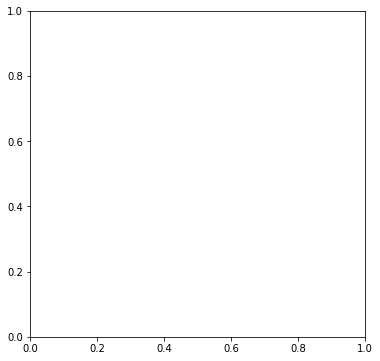

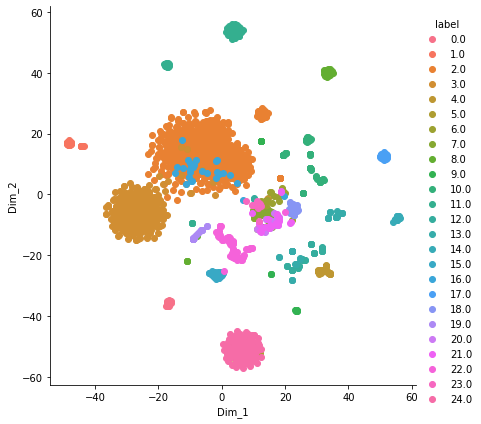

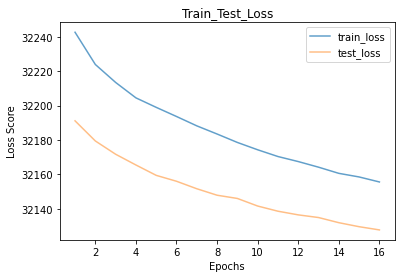

17
Train Epoch: 17 [0/7471 (0%)]	Loss: 32490.529297
Train Epoch: 17 [160/7471 (2%)]	Loss: 33212.726562
Train Epoch: 17 [320/7471 (4%)]	Loss: 31518.195312
Train Epoch: 17 [480/7471 (6%)]	Loss: 31022.273438
Train Epoch: 17 [640/7471 (9%)]	Loss: 32007.185547
Train Epoch: 17 [800/7471 (11%)]	Loss: 31316.708984
Train Epoch: 17 [960/7471 (13%)]	Loss: 33175.140625
Train Epoch: 17 [1120/7471 (15%)]	Loss: 32094.382812
Train Epoch: 17 [1280/7471 (17%)]	Loss: 32204.378906
Train Epoch: 17 [1440/7471 (19%)]	Loss: 32696.453125
Train Epoch: 17 [1600/7471 (21%)]	Loss: 32754.060547
Train Epoch: 17 [1760/7471 (24%)]	Loss: 30901.158203
Train Epoch: 17 [1920/7471 (26%)]	Loss: 32105.564453
Train Epoch: 17 [2080/7471 (28%)]	Loss: 32592.939453
Train Epoch: 17 [2240/7471 (30%)]	Loss: 30938.382812
Train Epoch: 17 [2400/7471 (32%)]	Loss: 32548.330078
Train Epoch: 17 [2560/7471 (34%)]	Loss: 32669.171875
Train Epoch: 17 [2720/7471 (36%)]	Loss: 33559.652344
Train Epoch: 17 [2880/7471 (39%)]	Loss: 33481.964844
Trai

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


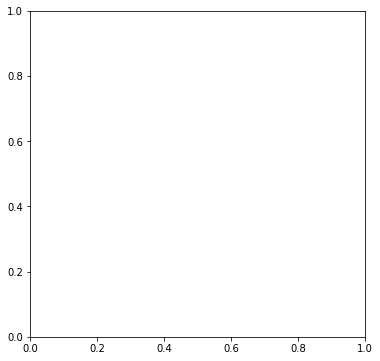

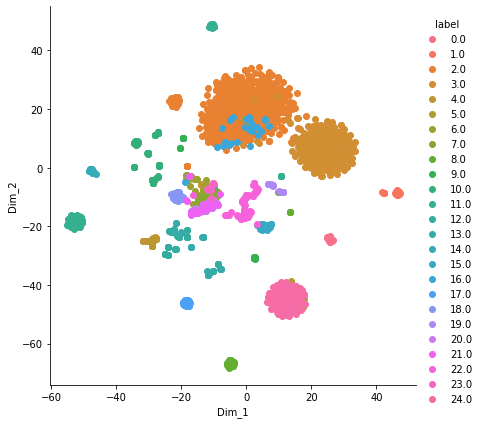

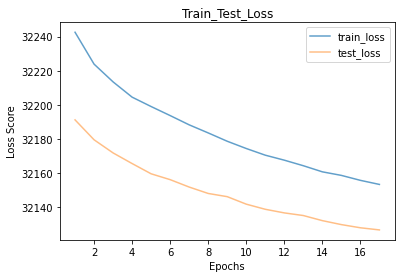

18
Train Epoch: 18 [0/7471 (0%)]	Loss: 33365.312500
Train Epoch: 18 [160/7471 (2%)]	Loss: 32369.246094
Train Epoch: 18 [320/7471 (4%)]	Loss: 33255.933594
Train Epoch: 18 [480/7471 (6%)]	Loss: 32746.855469
Train Epoch: 18 [640/7471 (9%)]	Loss: 31135.699219
Train Epoch: 18 [800/7471 (11%)]	Loss: 32244.052734
Train Epoch: 18 [960/7471 (13%)]	Loss: 30095.699219
Train Epoch: 18 [1120/7471 (15%)]	Loss: 33366.093750
Train Epoch: 18 [1280/7471 (17%)]	Loss: 33290.214844
Train Epoch: 18 [1440/7471 (19%)]	Loss: 32033.898438
Train Epoch: 18 [1600/7471 (21%)]	Loss: 33222.542969
Train Epoch: 18 [1760/7471 (24%)]	Loss: 33341.609375
Train Epoch: 18 [1920/7471 (26%)]	Loss: 33398.246094
Train Epoch: 18 [2080/7471 (28%)]	Loss: 31686.421875
Train Epoch: 18 [2240/7471 (30%)]	Loss: 32779.203125
Train Epoch: 18 [2400/7471 (32%)]	Loss: 32974.863281
Train Epoch: 18 [2560/7471 (34%)]	Loss: 32357.806641
Train Epoch: 18 [2720/7471 (36%)]	Loss: 32748.423828
Train Epoch: 18 [2880/7471 (39%)]	Loss: 32992.132812
Trai

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


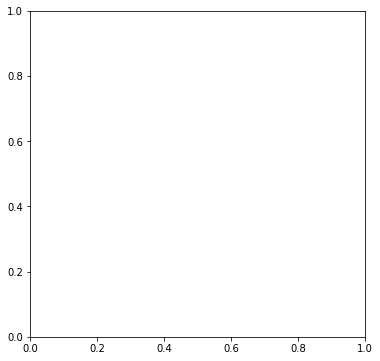

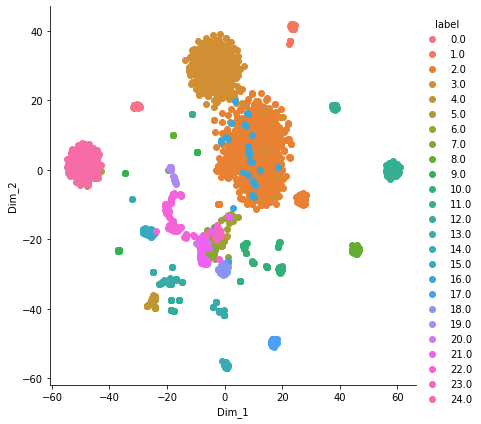

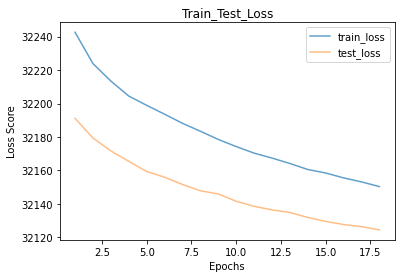

19
Train Epoch: 19 [0/7471 (0%)]	Loss: 31975.664062
Train Epoch: 19 [160/7471 (2%)]	Loss: 31866.513672
Train Epoch: 19 [320/7471 (4%)]	Loss: 32939.078125
Train Epoch: 19 [480/7471 (6%)]	Loss: 30864.619141
Train Epoch: 19 [640/7471 (9%)]	Loss: 32090.525391
Train Epoch: 19 [800/7471 (11%)]	Loss: 31597.480469
Train Epoch: 19 [960/7471 (13%)]	Loss: 32257.630859
Train Epoch: 19 [1120/7471 (15%)]	Loss: 33235.152344
Train Epoch: 19 [1280/7471 (17%)]	Loss: 31727.984375
Train Epoch: 19 [1440/7471 (19%)]	Loss: 30239.507812
Train Epoch: 19 [1600/7471 (21%)]	Loss: 31868.867188
Train Epoch: 19 [1760/7471 (24%)]	Loss: 32260.910156
Train Epoch: 19 [1920/7471 (26%)]	Loss: 32412.476562
Train Epoch: 19 [2080/7471 (28%)]	Loss: 32035.898438
Train Epoch: 19 [2240/7471 (30%)]	Loss: 32096.511719
Train Epoch: 19 [2400/7471 (32%)]	Loss: 31126.656250
Train Epoch: 19 [2560/7471 (34%)]	Loss: 32094.687500
Train Epoch: 19 [2720/7471 (36%)]	Loss: 32232.007812
Train Epoch: 19 [2880/7471 (39%)]	Loss: 32399.515625
Trai

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


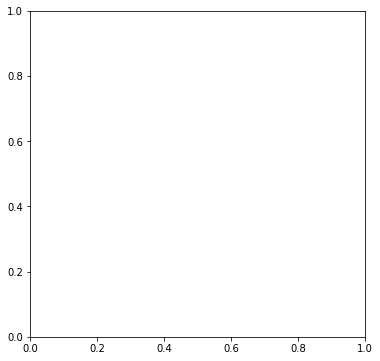

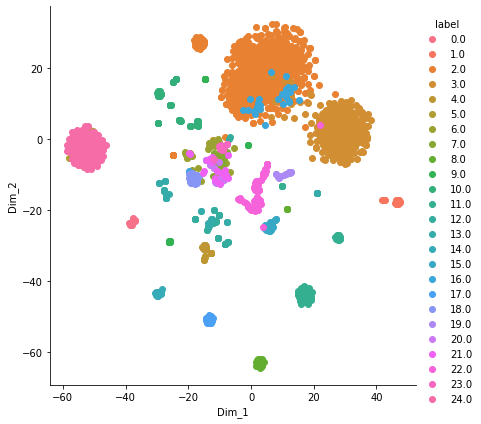

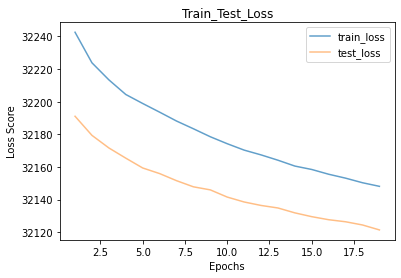

20
Train Epoch: 20 [0/7471 (0%)]	Loss: 33054.656250
Train Epoch: 20 [160/7471 (2%)]	Loss: 31334.455078
Train Epoch: 20 [320/7471 (4%)]	Loss: 31818.982422
Train Epoch: 20 [480/7471 (6%)]	Loss: 32223.724609
Train Epoch: 20 [640/7471 (9%)]	Loss: 33184.125000
Train Epoch: 20 [800/7471 (11%)]	Loss: 32695.607422
Train Epoch: 20 [960/7471 (13%)]	Loss: 32972.976562
Train Epoch: 20 [1120/7471 (15%)]	Loss: 32086.402344
Train Epoch: 20 [1280/7471 (17%)]	Loss: 32121.138672
Train Epoch: 20 [1440/7471 (19%)]	Loss: 33016.375000
Train Epoch: 20 [1600/7471 (21%)]	Loss: 31335.431641
Train Epoch: 20 [1760/7471 (24%)]	Loss: 31814.640625
Train Epoch: 20 [1920/7471 (26%)]	Loss: 32506.259766
Train Epoch: 20 [2080/7471 (28%)]	Loss: 33373.074219
Train Epoch: 20 [2240/7471 (30%)]	Loss: 31588.974609
Train Epoch: 20 [2400/7471 (32%)]	Loss: 32608.566406
Train Epoch: 20 [2560/7471 (34%)]	Loss: 32787.667969
Train Epoch: 20 [2720/7471 (36%)]	Loss: 31347.878906
Train Epoch: 20 [2880/7471 (39%)]	Loss: 31482.445312
Trai

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


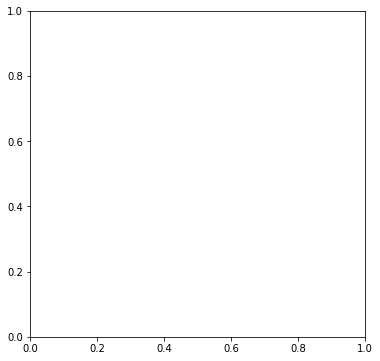

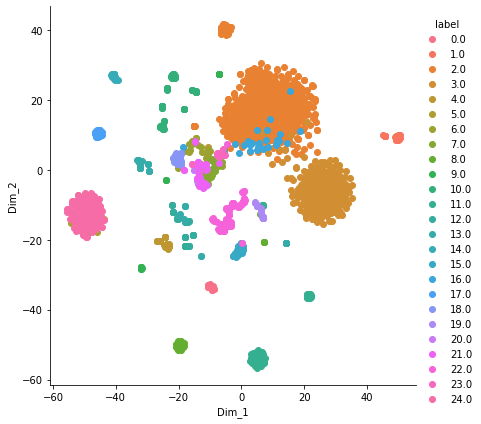

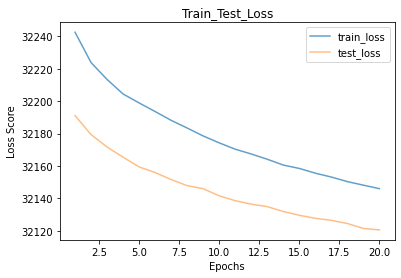

In [25]:
epochs = 20

for epoch in range(1, epochs + 1):
        print(epoch)
        train(epoch)
        test(epoch)
        # https://stackoverflow.com/questions/40766909/suggestions-to-plot-overlapping-lines-in-matplotlib
        plt.plot(Epoch_Loss['train_epoch'],Epoch_Loss['train_loss'], label="train_loss", alpha=0.7)
        plt.plot(Epoch_Loss['test_epoch'],Epoch_Loss['test_loss'], label="test_loss", alpha=0.5)
        plt.xlabel('Epochs')
        plt.ylabel('Loss Score')
        plt.title('Train_Test_Loss')
        plt.legend()
        plt.savefig('./Exp07_results/plot_train_test_loss/'+str(epoch)+'_epoch.png', dpi=300)
        plt.show()

        with torch.no_grad():
            sample = torch.randn(64, 100).to(device)
            sample = model.decode(sample).cpu()
            save_image(sample.view(64, 1, 224, 224),
                       './Exp07_results/recon_sampling/sampling_' + str(epoch) + '.png')

### Training 일지

1. Loss값이 수렴된 이후 Learning rate를 줄여 학습하면 어떻게 될까?
 

 * 이번 실험의 결과도 기대가 된다